In [1]:
import os

import numpy as np
import importlib
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt

import gym_env
from models import SR_IS
from utils import get_full_maze_values, policy_reval, decision_policy, update_terminal_reward
from utils_render import plot_decision_prob

In [2]:
# Set the random seed for NumPy
seed = 24
np.random.seed(seed)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# For plotting
idx = 0    # 7x7 maze
prob_locs = [1, 7]   # 7x7 maze
colors = [4, 9]

In [4]:
def choose(probs):
    return np.random.choice([0,1], p=probs)

## Train Agents

In [5]:
mazes = ["simple-5x5-2", "simple-7x7-2", "maze-10x10-two-goal"]
maze_name = mazes[1]

### D_inv agent

In [6]:
# Agent to be used with D_inv
agent = SR_IS(env_name=maze_name)
# Make the reward for the first terminal state higher than the second to bias the DR towards that terminal state
update_terminal_reward(agent, loc=0, r=10)
update_terminal_reward(agent, loc=1, r=8)

agent.DR = agent.gamma * agent.get_D_inv()
agent.update_V()
maze_values = get_full_maze_values(agent)

In [7]:
agent.expr_t

array([22026.46579481,  2980.95798704])

In [8]:
agent.maze

array([['S', '0', '0', '0', '0', '0', '0'],
       ['0', '1', '1', '0', '0', '0', '0'],
       ['0', '1', '1', '1', '0', 'G', '0'],
       ['0', '0', '1', '1', '1', '0', '0'],
       ['0', '0', '0', '0', '1', '0', '0'],
       ['0', '0', '0', '0', '0', '0', '0'],
       ['0', '0', '0', 'G', '0', '0', '0']], dtype='<U21')

In [9]:
pii_old_inv = decision_policy(agent, agent.Z)

In [10]:
# Update the second terminal state to make it double that of the first
update_terminal_reward(agent, loc=1, r=14)
V_new, Z_new = policy_reval(agent=agent)

In [11]:
agent.V = V_new
maze_values = get_full_maze_values(agent)

In [12]:
agent.update_V()
pii_new_inv = decision_policy(agent, Z_new)

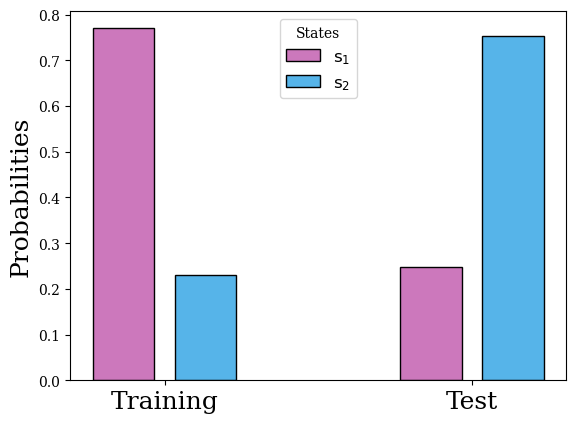

In [13]:
save_path = save_dir + 'policy_reval_10x10_inv.png'
plot_decision_prob(probs_train=pii_old_inv[idx][prob_locs], probs_test=pii_new_inv[idx][prob_locs], colors=colors, leg_loc="upper center", save_path=None)

## Reward Revaluation

### Agent with importance sampling

In [14]:
avg_old, avg_new = np.array([0.0,0.0]), np.array([0.0,0.0])

num_iterations = 20

for i in range(num_iterations):
    # Initialize the agent
    agent_with_imp = SR_IS(env_name=maze_name, reward=-0.2, _lambda=1, alpha=0.2, beta=0.7, num_steps=10000, policy="softmax", imp_samp=True)

    # Initialize terminal state rewards
    update_terminal_reward(agent_with_imp, loc=0, r=10)
    update_terminal_reward(agent_with_imp, loc=1, r=8)

    # Train the agent with importance sampling
    agent_with_imp.learn(seed=int(i))

    # Get the old policy
    pii_old_with = decision_policy(agent_with_imp, agent_with_imp.Z)

    # Update rewards at second terminal state and get new policy
    update_terminal_reward(agent_with_imp, loc=1, r=14)
    V_new, Z_new = policy_reval(agent=agent_with_imp)

    agent_with_imp.update_V()
    pii_new_with = decision_policy(agent_with_imp, Z_new)

    dec_old = choose(probs=pii_old_with[idx][prob_locs])
    dec_new = choose(probs=pii_new_with[idx][prob_locs])
    avg_old[dec_old] += 1
    avg_new[dec_new] += 1

avg_old /= num_iterations
avg_new /= num_iterations

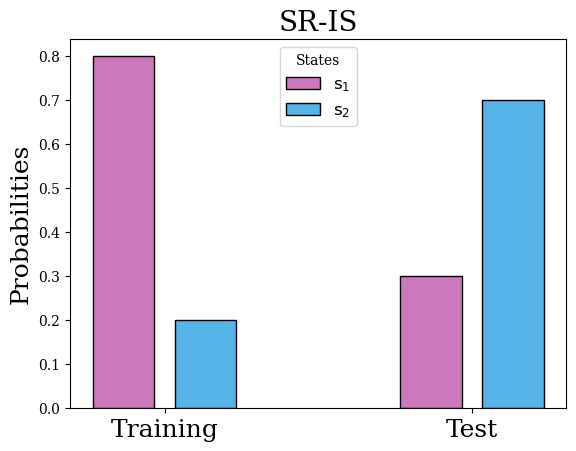

In [15]:
save_path = save_dir + 'reward_reval_7x7_with_is.png'
plot_decision_prob(probs_train=avg_old, probs_test=avg_new, colors=colors, leg_loc='upper center', save_path=save_path, title='SR-IS')

### Agent without importance sampling

In [16]:
avg_old, avg_new = np.array([0.0,0.0]), np.array([0.0,0.0])
num_iterations = 20

for i in range(num_iterations):
    # Initialize agent
    agent_no_imp = SR_IS(env_name=maze_name, _lambda=1, alpha=0.2, beta=0.7, num_steps=10000, policy="softmax", imp_samp=False)

    # Initialize terminal state rewards
    update_terminal_reward(agent_no_imp, loc=0, r=10)
    update_terminal_reward(agent_no_imp, loc=1, r=8)

    # Train agent without importance sampling
    agent_no_imp.learn(seed=int(i))

    # Get old policy
    pii_old_without = decision_policy(agent_no_imp, agent_no_imp.Z)

    # Update terminal state rewards at second location and get new policy
    update_terminal_reward(agent_no_imp, loc=1, r=14)
    V_new, Z_new = policy_reval(agent=agent_no_imp)

    agent_no_imp.update_V()
    pii_new_without = decision_policy(agent_no_imp, Z_new)

    dec_old = choose(probs=pii_old_with[idx][prob_locs])
    dec_new = choose(probs=pii_new_with[idx][prob_locs])
    avg_old[dec_old] += 1
    avg_new[dec_new] += 1

avg_old /= num_iterations
avg_new /= num_iterations

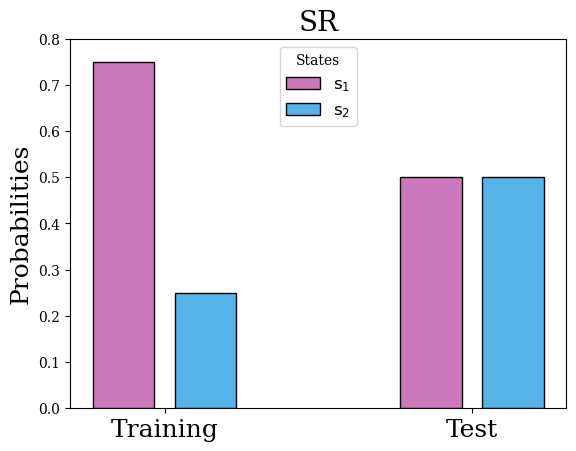

In [18]:
save_path = save_dir + 'reward_reval_7x7_without_is.png'
plot_decision_prob(probs_train=avg_old, probs_test=avg_new, colors=colors, leg_loc='upper center', save_path=save_path, title='SR')

## Policy revaluation

### Agent with importance sampling

In [19]:
avg_old, avg_new = np.array([0.0,0.0]), np.array([0.0,0.0])
num_iterations = 20

for i in range(num_iterations):
    # Initialize the agent
    agent_with_imp = SR_IS(env_name=maze_name, reward=-0.2, _lambda=1, alpha=0.2, beta=0.7, num_steps=10000, policy="softmax", imp_samp=True)

    # Initialize terminal state rewards
    update_terminal_reward(agent_with_imp, loc=0, r=10)
    update_terminal_reward(agent_with_imp, loc=1, r=0)

    # Train the agent with importance sampling
    agent_with_imp.learn(seed=int(i))

    # Get the old policy
    pii_old_with = decision_policy(agent_with_imp, agent_with_imp.Z)

    # Update rewards at second terminal state and get new policy
    update_terminal_reward(agent_with_imp, loc=1, r=14)
    V_new, Z_new = policy_reval(agent=agent_with_imp)

    agent_with_imp.update_V()
    pii_new_with = decision_policy(agent_with_imp, Z_new)
    
    dec_old = choose(probs=pii_old_with[idx][prob_locs])
    dec_new = choose(probs=pii_new_with[idx][prob_locs])
    avg_old[dec_old] += 1
    avg_new[dec_new] += 1

avg_old /= num_iterations
avg_new /= num_iterations

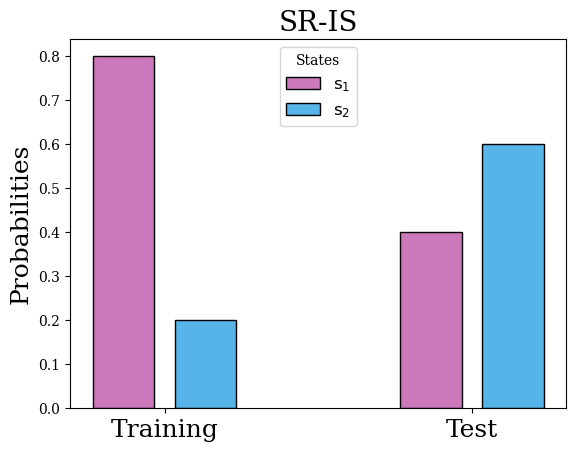

In [21]:
plot_decision_prob(probs_train=avg_old, probs_test=avg_new, colors=colors, leg_loc='upper center', save_path=save_path, title='SR-IS')

### Agent without importance sampling

In [22]:
avg_old, avg_new = np.array([0.0,0.0]), np.array([0.0,0.0])
num_iterations = 20

for i in range(num_iterations):
    # Initialize agent
    agent_no_imp = SR_IS(env_name=maze_name, _lambda=1, alpha=0.2, beta=0.6, num_steps=10000, policy="softmax", imp_samp=False)

    # Initialize terminal state rewards
    update_terminal_reward(agent_no_imp, loc=0, r=10)
    update_terminal_reward(agent_no_imp, loc=1, r=0)

    # Train agent without importance sampling
    agent_no_imp.learn(seed=int(i))

    # Get old policy
    pii_old_without = decision_policy(agent_no_imp, agent_no_imp.Z)

    # Update terminal state rewards at second location and get new policy
    update_terminal_reward(agent_no_imp, loc=1, r=14)
    V_new, Z_new = policy_reval(agent=agent_no_imp)

    agent_no_imp.update_V()
    pii_new_without = decision_policy(agent_no_imp, Z_new)

    dec_old = choose(probs=pii_old_with[idx][prob_locs])
    dec_new = choose(probs=pii_new_with[idx][prob_locs])
    avg_old[dec_old] += 1
    avg_new[dec_new] += 1

avg_old /= num_iterations
avg_new /= num_iterations

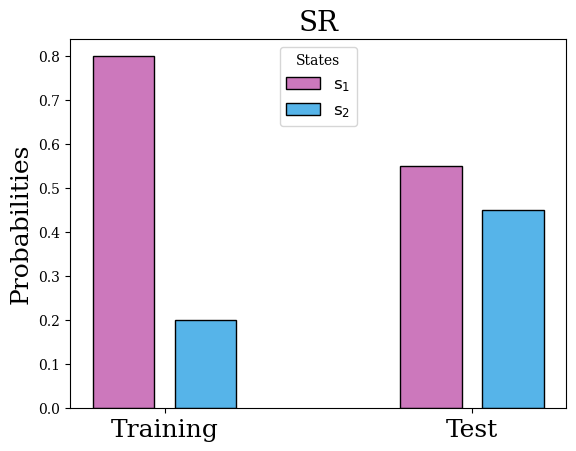

In [24]:
save_path = save_dir + 'policy_reval_7x7_without_is.png'
plot_decision_prob(probs_train=avg_old, probs_test=avg_new, colors=colors, leg_loc='upper center', save_path=save_path, title="SR")